
=== Stationarity Check (ADF Test) ===
ADF Statistic: -5.1055
p-value: 0.0000
The series IS stationary (reject H0)

=== Data Splits ===
Train dates: 2016-02-15 to 2023-02-15 (n=590)
Test dates: 2023-03-15 to 2024-01-15 (n=77)
Unseen dates: 2024-03-15 to 2024-12-15 (n=70)

Best Params: {'batch_size': 16, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__units': 128}

Standard prediction on test set:
RMSE: 66.085 | MAE: 56.529 | AIC: 397191.405 | BIC: 861904.737

Standard prediction on unseen set:
RMSE: 82.588 | MAE: 67.292 | AIC: 397163.942 | BIC: 842979.839

Rolling forecast on test set:
RMSE: 68.721 | MAE: 57.727 | AIC: 397197.428 | BIC: 861910.761

Rolling forecast on unseen set:
RMSE: 88.053 | MAE: 71.306 | AIC: 397172.912 | BIC: 842988.809


<Figure size 1200x600 with 0 Axes>

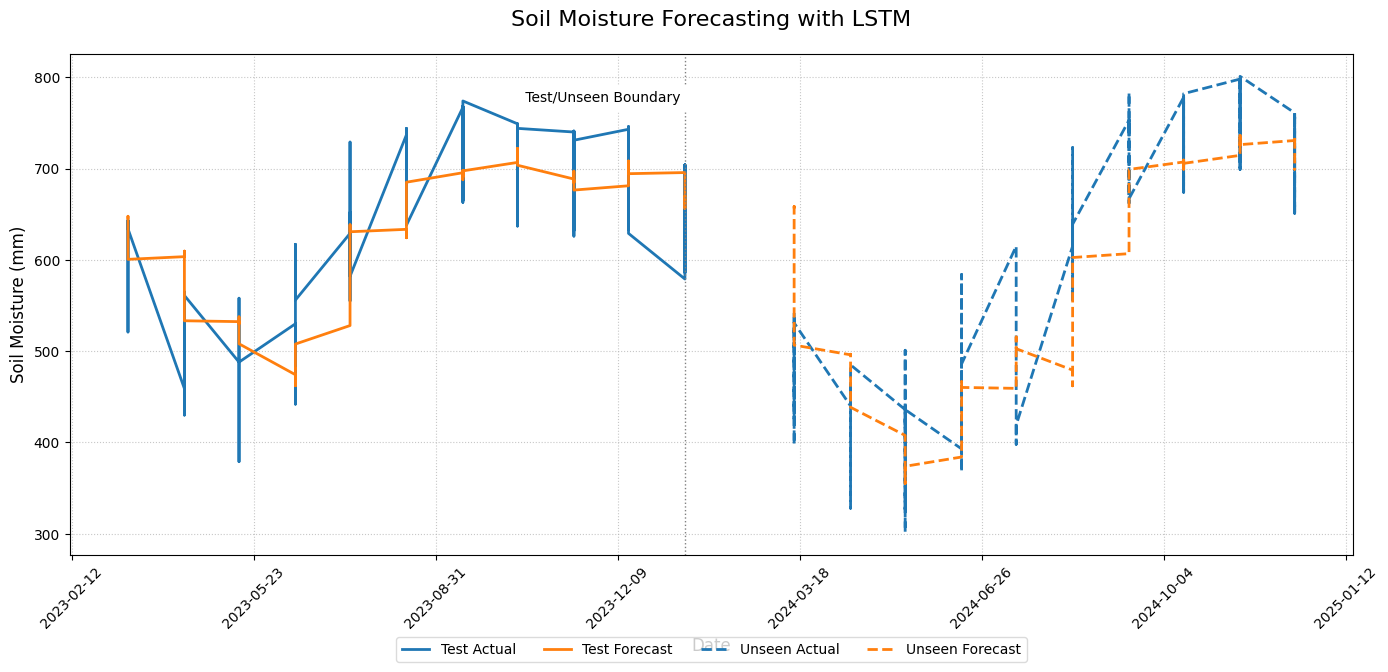

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from math import log
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Load and preprocess data
# ------------------------------
data = pd.read_csv('Apayao.csv')

# Convert and filter dates
data['Date'] = pd.to_datetime(data['Time'], format='%m/%d/%Y')
data = data[data['Date'].dt.year >= 2016]
data = data.sort_values('Date')  # Ensure chronological order
data.set_index('Date', inplace=True)

# ------------------------------
# Stationarity check (ADF test)
# ------------------------------
from statsmodels.tsa.stattools import adfuller

soil_moisture_series = data['Soil Moisture (mm)'].dropna()
result = adfuller(soil_moisture_series)
test_stat, p_value = result[0], result[1]

print("\n=== Stationarity Check (ADF Test) ===")
print(f"ADF Statistic: {test_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The series IS stationary (reject H0)")
else:
    print("The series is NOT stationary (fail to reject H0)")

features = ['Soil Moisture (mm)']
target = 'Soil Moisture (mm)'

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[features + [target]])

X_all = scaled[:, :-1]
y_all = scaled[:, -1]

# ------------------------------
# 2. Create sequences (windowed data)
# ------------------------------
window_size = 12
X_seq, y_seq = [], []
target_dates = data.index[window_size:]

for i in range(window_size, len(X_all)):
    X_seq.append(X_all[i - window_size:i, :])
    y_seq.append(y_all[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# ------------------------------
# 3. Split into train/test/unseen with clear boundaries
# ------------------------------
# Get the actual date ranges for splits
total_dates = data.index[window_size:]
split_date1 = total_dates[int(len(total_dates) * 0.8)]  # 80% for train
split_date2 = total_dates[int(len(total_dates) * 0.9)]  # 90% for train+test

# Get indices based on dates
train_idx = total_dates <= split_date1
test_idx = (total_dates > split_date1) & (total_dates <= split_date2)
unseen_idx = total_dates > split_date2

# Apply the splits
X_train, y_train = X_seq[train_idx], y_seq[train_idx]
dates_train = total_dates[train_idx]

X_test, y_test = X_seq[test_idx], y_seq[test_idx]
dates_test = total_dates[test_idx]

X_unseen, y_unseen = X_seq[unseen_idx], y_seq[unseen_idx]
dates_unseen = total_dates[unseen_idx]

# Verify no overlap
assert len(set(dates_train) & set(dates_test)) == 0
assert len(set(dates_train) & set(dates_unseen)) == 0
assert len(set(dates_test) & set(dates_unseen)) == 0

print(f"\n=== Data Splits ===")
print(f"Train dates: {dates_train.min().date()} to {dates_train.max().date()} (n={len(X_train)})")
print(f"Test dates: {dates_test.min().date()} to {dates_test.max().date()} (n={len(X_test)})")
print(f"Unseen dates: {dates_unseen.min().date()} to {dates_unseen.max().date()} (n={len(X_unseen)})")

# ------------------------------
# 4. Build LSTM model
# ------------------------------
def build_model(units=128, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(window_size, len(features))),
        LSTM(units=units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# ------------------------------
# 5. GridSearchCV
# ------------------------------
param_grid = {
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.3],
    'epochs': [50],
    'batch_size': [16, 32]
}

tscv = TimeSeriesSplit(n_splits=3)

keras_reg = KerasRegressor(
    model=build_model,
    optimizer='adam',
    loss='mean_squared_error',
    epochs=50,
    batch_size=32,
    verbose=0
)

grid = GridSearchCV(estimator=keras_reg, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train, y_train)
best_model = grid_result.best_estimator_.model_

print(f'\nBest Params: {grid_result.best_params_}')

k = best_model.count_params()

# ------------------------------
# 6. Predictions (standard)
# ------------------------------
def inverse_scale_predictions(y_pred_scaled):
    return scaler.inverse_transform(
        np.hstack([np.zeros((len(y_pred_scaled), len(features))), y_pred_scaled.reshape(-1,1)])
    )[:, -1]

# Test set predictions
y_test_pred_scaled = best_model.predict(X_test, verbose=0)
y_test_pred = inverse_scale_predictions(y_test_pred_scaled)
y_test_true = inverse_scale_predictions(y_test)

# Unseen set predictions
y_unseen_pred_scaled = best_model.predict(X_unseen, verbose=0)
y_unseen_pred = inverse_scale_predictions(y_unseen_pred_scaled)
y_unseen_true = inverse_scale_predictions(y_unseen)

# ------------------------------
# 7. Rolling forecast
# ------------------------------
def rolling_forecast(model, initial_data, X_to_predict):
    predictions = []
    history = list(initial_data)

    for i in range(len(X_to_predict)):
        # Prepare input sequence
        input_seq = np.array(history[-1]).reshape((1, window_size, len(features)))

        # Make prediction
        pred_scaled = model.predict_on_batch(input_seq)[0][0]
        predictions.append(pred_scaled)

        # Update history with new observation
        new_observation = X_to_predict[i][-1].reshape(1, -1)
        next_input = np.vstack([history[-1][1:], new_observation])
        history.append(next_input)

    return inverse_scale_predictions(np.array(predictions))

# Test set rolling forecast
rolling_preds_test = rolling_forecast(best_model, list(X_train), X_test)

# Unseen set rolling forecast (using train + test as history)
rolling_preds_unseen = rolling_forecast(best_model, list(np.vstack((X_train, X_test))), X_unseen)

# ------------------------------
# 8. Compute metrics
# ------------------------------
def compute_metrics(y_true, y_pred, k):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    rss = np.sum((y_true - y_pred)**2)
    mse = rss / len(y_true)
    aic = len(y_true) * log(mse) + 2 * k
    bic = len(y_true) * log(mse) + k * log(len(y_true))
    return rmse, mae, aic, bic

metrics_test = compute_metrics(y_test_true, y_test_pred, k)
metrics_unseen = compute_metrics(y_unseen_true, y_unseen_pred, k)
metrics_roll_test = compute_metrics(y_test_true, rolling_preds_test, k)
metrics_roll_unseen = compute_metrics(y_unseen_true, rolling_preds_unseen, k)

# ------------------------------
# 9. Print results
# ------------------------------
print(f"\nStandard prediction on test set:")
print(f"RMSE: {metrics_test[0]:.3f} | MAE: {metrics_test[1]:.3f} | AIC: {metrics_test[2]:.3f} | BIC: {metrics_test[3]:.3f}")

print(f"\nStandard prediction on unseen set:")
print(f"RMSE: {metrics_unseen[0]:.3f} | MAE: {metrics_unseen[1]:.3f} | AIC: {metrics_unseen[2]:.3f} | BIC: {metrics_unseen[3]:.3f}")

print(f"\nRolling forecast on test set:")
print(f"RMSE: {metrics_roll_test[0]:.3f} | MAE: {metrics_roll_test[1]:.3f} | AIC: {metrics_roll_test[2]:.3f} | BIC: {metrics_roll_test[3]:.3f}")

print(f"\nRolling forecast on unseen set:")
print(f"RMSE: {metrics_roll_unseen[0]:.3f} | MAE: {metrics_roll_unseen[1]:.3f} | AIC: {metrics_roll_unseen[2]:.3f} | BIC: {metrics_roll_unseen[3]:.3f}")

# ------------------------------
# 10. Plot results
# ------------------------------
plt.figure(figsize=(12,6))
# plt.plot(dates_train, inverse_scale_predictions(y_train), 'g-', alpha=0.3, label='Training Data')
# plt.plot(dates_test, y_test_true, 'b-', label='Test Actual')
# plt.plot(dates_test, rolling_preds_test, 'r-', label='Test Rolling Forecast')
# plt.plot(dates_unseen, y_unseen_true, 'b--', label='Unseen Actual')
# plt.plot(dates_unseen, rolling_preds_unseen, 'r--', label='Unseen Rolling Forecast')
#
# plt.title('Soil Moisture Rolling Forecast')
# plt.xlabel('Date')
# plt.ylabel('Soil Moisture (mm)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# ------------------------------
# 10. Enhanced Plot
# ------------------------------
plt.figure(figsize=(14, 7))

# Create the plot with improved styling
test_line, = plt.plot(dates_test, y_test_true, color='#1f77b4', linewidth=2, label='Test Actual')
test_fcst, = plt.plot(dates_test, rolling_preds_test, color='#ff7f0e', linestyle='-', linewidth=2, label='Test Forecast')

unseen_line, = plt.plot(dates_unseen, y_unseen_true, color='#1f77b4', linestyle='--', linewidth=2, label='Unseen Actual')
unseen_fcst, = plt.plot(dates_unseen, rolling_preds_unseen, color='#ff7f0e', linestyle='--', linewidth=2, label='Unseen Forecast')

# Highlight the test/unseen boundary
split_date = dates_test[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1)
plt.text(split_date, plt.ylim()[1]*0.95, ' Test/Unseen Boundary ',
         ha='right', va='top', backgroundcolor='white')

# Add improved styling
plt.title('Soil Moisture Forecasting with LSTM', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Soil Moisture (mm)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)

# Custom legend
legend = plt.legend(handles=[test_line, test_fcst, unseen_line, unseen_fcst],
                    loc='upper center',
                    bbox_to_anchor=(0.5, -0.15),
                    ncol=4,
                    frameon=True,
                    fontsize=10)
legend.get_frame().set_edgecolor('lightgray')

# Format x-axis
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.xticks(rotation=45)
plt.tight_layout()

# Add some space for the legend
plt.subplots_adjust(bottom=0.2)

plt.show()